In [60]:
import pyspark

In [61]:
from pyspark.sql import SparkSession

In [62]:
# Creating a Spark session
spark = SparkSession.builder.appName("SP500 Companies Analysis").getOrCreate()

In [170]:
columns = 'Exchange string, Symbol string, Shortname string, Longname string, Sector string, Industry string, Currentprice double, Marketcap double, Ebitda double, Revenuegrowth double, City string, State string, Country string, Fulltimeemployees double, Longbusinesssummary string, Weight double'

In [171]:
df = spark.read.csv("sp500_companies.csv", header=True, schema=columns)

In [172]:
df.show(5)

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|     NMS|  AAPL|          Apple Inc.|          Apple Inc.|          Technology|Consumer Electronics|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|    Cupertino|   CA|United States|         161000.0|Apple Inc. 

In [173]:
df.printSchema()

root
 |-- Exchange: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Shortname: string (nullable = true)
 |-- Longname: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Currentprice: double (nullable = true)
 |-- Marketcap: double (nullable = true)
 |-- Ebitda: double (nullable = true)
 |-- Revenuegrowth: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Fulltimeemployees: double (nullable = true)
 |-- Longbusinesssummary: string (nullable = true)
 |-- Weight: double (nullable = true)



In [174]:
df.describe()

DataFrame[summary: string, Exchange: string, Symbol: string, Shortname: string, Longname: string, Sector: string, Industry: string, Currentprice: string, Marketcap: string, Ebitda: string, Revenuegrowth: string, City: string, State: string, Country: string, Fulltimeemployees: string, Longbusinesssummary: string, Weight: string]

In [175]:
df.describe().show()

+-------+--------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|summary|Exchange|              Symbol|           Shortname|            Longname|              Sector|        Industry|      Currentprice|           Marketcap|              Ebitda|      Revenuegrowth|                City|               State|             Country| Fulltimeemployees| Longbusinesssummary|              Weight|
+-------+--------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|  count|     504|       

In [176]:
from pyspark.sql.functions import col, isnan, count, when

In [177]:
# Count NULL values in each column
null_counts = df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
)
null_counts.show()

+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|Exchange|Symbol|Shortname|Longname|Sector|Industry|Currentprice|Marketcap|Ebitda|Revenuegrowth|City|State|Country|Fulltimeemployees|Longbusinesssummary|Weight|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|       0|     0|        0|       0|     0|       0|           1|        1|    30|            3|   0|   20|      0|                9|                  0|     5|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+



In [178]:
# Calculate median for numeric columns using approxQuantile
ebitda_median = df.approxQuantile("Ebitda", [0.5], 0.25)[0]
fulltimeemployees_median = df.approxQuantile("Fulltimeemployees", [0.5], 0.25)[0]
revenuegrowth_median = df.approxQuantile("Revenuegrowth", [0.5], 0.25)[0]
weight_median = df.approxQuantile("Weight", [0.5], 0.25)[0]

# Calculate mode for 'State' column
state_mode = df.groupBy("State").count().orderBy("count", ascending=False).first()[0]

In [179]:
# Fill missing values
df = df.fillna({
    'Ebitda': ebitda_median,
    'State': state_mode,
    'Fulltimeemployees': fulltimeemployees_median,
    'Revenuegrowth': revenuegrowth_median,
    'Weight': weight_median
})

In [180]:
df = df.dropna()

In [181]:
# Verify no missing values remain
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|Exchange|Symbol|Shortname|Longname|Sector|Industry|Currentprice|Marketcap|Ebitda|Revenuegrowth|City|State|Country|Fulltimeemployees|Longbusinesssummary|Weight|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|       0|     0|        0|       0|     0|       0|           0|        0|     0|            0|   0|    0|      0|                0|                  0|     0|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+



In [182]:
df.show(5)

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|     NMS|  AAPL|          Apple Inc.|          Apple Inc.|          Technology|Consumer Electronics|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|    Cupertino|   CA|United States|         161000.0|Apple Inc. 

In [183]:
# Group by 'Sector' and count the number of companies in each sector
sector_counts = df.groupBy("Sector").agg(count("Symbol").alias("count")).orderBy("count", ascending=False)
sector_counts.show()

+--------------------+-----+
|              Sector|count|
+--------------------+-----+
|          Technology|   78|
|         Industrials|   72|
|  Financial Services|   66|
|          Healthcare|   64|
|   Consumer Cyclical|   57|
|  Consumer Defensive|   37|
|           Utilities|   32|
|         Real Estate|   31|
|Communication Ser...|   22|
|              Energy|   22|
|     Basic Materials|   22|
+--------------------+-----+



In [184]:
# Describe numerical columns to get summary statistics
df.select("Currentprice", "Marketcap", "Ebitda", "Revenuegrowth", "Fulltimeemployees", "Weight").describe().show()

+-------+------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|summary|      Currentprice|           Marketcap|              Ebitda|      Revenuegrowth| Fulltimeemployees|              Weight|
+-------+------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|  count|               503|                 503|                 503|                503|               503|                 503|
|   mean|209.41182902584515|9.906873796555069E10|  6.47823617304175E9|0.05466799204771371| 57356.61232604374|0.001986012472757774|
| stddev|463.47639000424743|2.932765817004652E11|1.448644224189258...|0.19699887533134974|138453.33089867877|0.005885826487013507|
|    min|              8.27|       6.324059648E9|      -4.107000064E9|             -0.573|              28.0|1.269086843640927...|
|    max|           8546.26|     3.3713553408E12|    1.31781001216E11|             

In [185]:
from pyspark.ml.feature import StringIndexer

In [186]:
# List of columns to be indexed
categorical_columns = ["Exchange", "Sector", "Industry", "State", "Country"]

for i in categorical_columns:
    # Initialize the StringIndexer for the 'Sector' column
    indexer = StringIndexer(inputCol=f"{i}", outputCol=f"{i}Index")

    # Fit the indexer to the DataFrame and transform it
    df = indexer.fit(df).transform(df)

# Show the transformed DataFrame with new columns
df.show(5)

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+-------------+-----------+-------------+----------+------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|ExchangeIndex|SectorIndex|IndustryIndex|StateIndex|CountryIndex|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+-------------+-----------+-------------+----------+------------+
|     NMS|  AAPL|          Apple I

In [187]:
df_lr = df.select('ExchangeIndex', 'SectorIndex', 'IndustryIndex', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'StateIndex', 'CountryIndex', 'Fulltimeemployees', 'Weight')
df_lr.show()

+-------------+-----------+-------------+------------+-----------------+----------------+-------------+----------+------------+-----------------+--------------------+
|ExchangeIndex|SectorIndex|IndustryIndex|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|StateIndex|CountryIndex|Fulltimeemployees|              Weight|
+-------------+-----------+-------------+------------+-----------------+----------------+-------------+----------+------------+-----------------+--------------------+
|          1.0|        0.0|         96.0|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|       0.0|         0.0|         161000.0| 0.06765500242555358|
|          1.0|        0.0|          4.0|      408.49|3.036322463744E12|1.29433001984E11|        0.152|      14.0|         0.0|         228000.0| 0.06093169745809642|
|          1.0|        0.0|          2.0|      107.27|2.638659715072E12| 4.9274998784E10|        2.621|       0.0|         0.0|          29600.0| 0.05295156142782785

In [192]:
from pyspark.ml.feature import VectorAssembler

In [191]:
features_columns = ['ExchangeIndex',
 'SectorIndex',
 'IndustryIndex',
 'Marketcap',
 'Ebitda',
 'Revenuegrowth',
 'StateIndex',
 'CountryIndex',
 'Fulltimeemployees',
 'Weight'
]
features_columns

['ExchangeIndex',
 'SectorIndex',
 'IndustryIndex',
 'Marketcap',
 'Ebitda',
 'Revenuegrowth',
 'StateIndex',
 'CountryIndex',
 'Fulltimeemployees',
 'Weight']

In [193]:
# Select relevant features for the model
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the data
df_lr = assembler.transform(df_lr)

In [197]:
# Select the label and features
df_lr = df_lr.select("features", col("Currentprice"))
df_lr.show()

+--------------------+------------+
|            features|Currentprice|
+--------------------+------------+
|[3.3713553408E12,...|      219.86|
|[3.036322463744E1...|      408.49|
|[2.638659715072E1...|      107.27|
|[2.06209155072E12...|       168.4|
|[2.060634292224E1...|      166.66|
|[1.761270956032E1...|       167.9|
|[1.234906382336E1...|      488.14|
|[9.22798784512E11...|      428.36|
|[7.24339851264E11...|      804.46|
|[6.69464854528E11...|      143.82|
|[6.63430823936E11...|      207.67|
|[5.66573203456E11...|      199.14|
|[5.50660734976E11...|       68.46|
|[5.42870700032E11...|      589.83|
|[5.24315492352E11...|      116.88|
|[5.1873267712E11,...|      266.58|
|[4.268302336E11,1...|      462.02|
|[4.00895574016E11...|      170.08|
|[3.95124375552E11...|      164.14|
|[3.67301001216E11...|      133.28|
+--------------------+------------+
only showing top 20 rows



In [198]:
# Split the data into training and test sets
train_data, test_data = df_lr.randomSplit([0.8, 0.2])

In [199]:
train_data.show()

+--------------------+------------+
|            features|Currentprice|
+--------------------+------------+
|[6.324059648E9,5....|        9.63|
|[7.004214272E9,2....|       15.93|
|[7.070002688E9,1....|       15.71|
|[7.525487616E9,1....|       33.04|
|[7.714613248E9,3....|       35.66|
|[7.762431488E9,6....|       62.19|
|[7.803202048E9,2....|        11.0|
|[8.180626944E9,1....|       56.94|
|[8.388238336E9,1....|       90.91|
|[8.415663104E9,2....|       53.23|
|[8.595315712E9,5....|      142.87|
|[8.6070528E9,1.94...|        76.8|
|[8.761244672E9,1....|       38.13|
|[8.846768128E9,7....|       63.46|
|[8.891749376E9,3....|      234.63|
|[9.006539776E9,1....|      173.25|
|[9.094181888E9,9....|       71.02|
|[9.347252224E9,5....|      335.93|
|[9.40151808E9,7.2...|      112.48|
|[9.436717056E9,6....|      164.31|
+--------------------+------------+
only showing top 20 rows



In [200]:
from pyspark.ml.regression import LinearRegression

In [201]:
# Create and train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="Currentprice")
lr_model = lr.fit(train_data)

In [202]:
# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print(f"R^2: {test_results.r2}\nRMSE: {test_results.rootMeanSquaredError}")

R^2: -0.5613199863743528
RMSE: 210.8331503621181


In [203]:
# Print the coefficients and intercept for linear regression
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [6.49532499897139e-09,-4.270290122072448e-09,247.34161986669847,-0.00010821376750501994,-308056.54847271164]
Intercept: 214.5545583282054


In [216]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)
predictions.show()

+--------------------+------------+------------------+
|            features|Currentprice|        prediction|
+--------------------+------------+------------------+
|[6.93997312E9,4.3...|       59.35|222.03061201672497|
|[7.411269632E9,1....|        33.2|206.98327158594407|
|[8.799739904E9,2....|       27.38|143.35308776105683|
|[1.03391744E10,1....|      263.35|224.89883468502413|
|[1.130139136E10,2...|       99.62|132.93522376132566|
|[1.1443195904E10,...|       21.88|228.60171734601096|
|[1.1549079552E10,...|       98.63| 217.5036021399241|
|[1.1796880384E10,...|       66.93|218.47047815835617|
|[1.2017627136E10,...|        82.4|229.80686216851495|
|[1.2033133568E10,...|       233.6|207.85803244005604|
|[1.2233472E10,9.6...|       78.38| 194.9514954005606|
|[1.240830976E10,5...|      170.21| 229.8642579729232|
|[1.3215837184E10,...|       40.19| 188.8012904692335|
|[1.3519960064E10,...|      353.39|203.54405932132505|
|[1.3629182976E10,...|       14.45| 209.1496714473247|
|[1.383232

In [219]:
pred_df = predictions.toPandas()
pred_df

,features,Currentprice,prediction
0,"[6939973120.0, 434888000.0, 0.03, 2420.0, 0.00...",59.35,222.030612
1,"[7411269632.0, 1568000000.0, -0.009, 8981.0, 0...",33.20,206.983272
2,"[8799739904.0, 2077600000.0, -0.257, 14049.0, ...",27.38,143.353088
3,"[10339174400.0, 1160000000.0, 0.068, 44000.0, ...",263.35,224.898835
4,"[11301391360.0, 2262000128.0, -0.202, 236000.0...",99.62,132.935224
...,...,...,...
119,"[426830233600.0, 16243999744.0, 0.11, 33400.0,...",462.02,302.537055
120,"[669464854528.0, 21290999808.0, 0.164, 20000.0...",143.82,371.825857
121,"[1761270956032.0, 104049000448.0, 0.101, 15250...",167.90,182.120372
122,"[2638659715072.0, 49274998784.0, 2.621, 29600....",107.27,1476.092437


In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

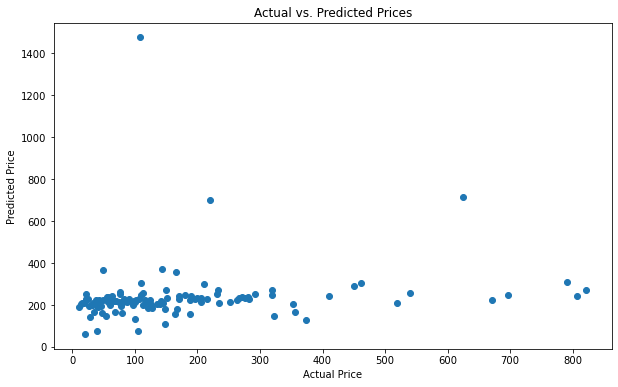

In [222]:
# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(pred_df['Currentprice'], pred_df['prediction'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()

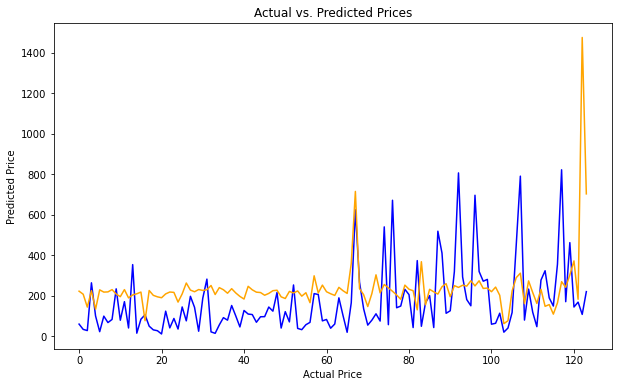

In [223]:
# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
n = np.arange(len(pred_df))
plt.plot(n, pred_df['Currentprice'], label='actual', color='blue')
plt.plot(n, pred_df['prediction'], label='prediction', color='orange')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()